In [1]:
import numpy as np, scipy as sp
import time
from matplotlib import pyplot as p
from importlib import reload

import scipy.linalg
import scipy.integrate

In [2]:
# we can get samples of j by floor(1/U) where U is uniform on (0, 1]
# floating point isn't perfect but it's close
def generateJ(shape):
    return np.floor(1/np.random.random(shape)).astype(int)
def generate_sum_of_j(count):
    return np.sum(generateJ(count))

In [3]:
many = 1000000

class progressbar:
    "A utility class to show progress on long tasks."
    def __init__(self):
        self.start = False
        self.length = 0
        
    def tell(self, z):
        if self.start:
            pad = self.length - len(z)
            if pad < 0:
                pad = 0
            print("\r" + z + " " * pad, end="")
        else:
            print(z, end="")
        self.start = True
        self.length = len(z)
        
    def done(self):
        print("")

def sample(many):
    samples = []
    count = 100000
    t = time.time()
    print("Generating %d samples of sums of %d independent copies of J" % (count, many))
    b = progressbar()
    for j in range(count):
        samples.append((generate_sum_of_j(many) - many * np.log(many)) / many)
        if time.time() > t + 1:
            b.tell("%9d/%9d generated" % (j, count))
            t += 1
    b.tell("%9d/%9d generated" % (count, count))
    b.done()
    return samples

# cumulative distribution function
def cdf(samples):
    x = np.sort(samples)
    y = np.arange(len(samples)) / len(samples)
    #pass
    #x = np.concatenate([[0], x])
    #y = np.concatenate([[0], y])
    p.plot(x, y)

We can get rigorous approximations of things like $\mathbb P(\mathfrak{J} < x)$ by using the formula
$$\mathbb P(X < x) = \frac12 - \frac{1}{2\pi{i}} \lim_{B \to \infty} \int_{-B}^{B} \left({e^{-ix\theta} \mathbb E[e^{iX\theta}] - 1 \over \theta}\right) \,d\theta$$
<!--$$\mathbb P(X < x) = \frac12 - \frac{1}{2\pi} \int_{-\infty}^{\infty} \mathop{\text{Im}} {e^{-ix\theta} \mathbb E[e^{iX\theta}] \over \theta} \,d\theta.$$-->

It would be nice to evaluate this integral with rigorous bounds for some values like $x = 0$. We can truncate it at e.g. $B = 100$ with very little error because $|\mathbb E[e^{iX\theta}]| = e^{-\pi |\theta| / 2}$ and $1/\theta$ cancels out on $[-B,-1] \cup [1,B]$. There is only a logarithmic singularity at zero, so the numerical integration routines in numpy work okay, but of course the bounds aren't rigorous. Anyway, it's plotted and compared to empirical estimate.

We compute the integral
$$\mathbb P(\mathfrak{J} < x) \approx {1 \over 2} - {1 \over 2 \pi i} \int_{-100}^{100} {e^{-ix\theta} \mathbb E[e^{iX\theta}] - 1 \over \theta} \,d\theta = {1 \over 2} - \int_{-100}^{100} {1 \over 2\pi \theta} \mathop{\text{Im}} (e^{-ix\theta} \mathbb E[e^{iX\theta}] - 1) \,d\theta$$

In our case, it is
$${1 \over 2} + \int_0^\infty {1 \over \pi \theta} e^{-\pi|\theta| / 2} \sin((x + \log |\theta|) \theta) \,d\theta.$$

#### a general function to compute cdf from cf

In [7]:
def cf_to_cdf(cf, x):
    "Given a characteristic function, compute P(X < x) by doing the funky integral."
    def f(z):
        return np.imag(cf(z) * np.exp(-1j*x*z) - cf(0)) / z / 2 / np.pi
    left_int, left_err = scipy.integrate.quad(f, -100, 0)
    right_int, right_err = scipy.integrate.quad(f, 0, 100)
    return 0.5 - (left_int + right_int)

class curlyj:
    @staticmethod
    def cf(theta):
        if theta == 0:
            return 1
        return np.exp(-1j*theta*np.log(-1j*theta))

    @staticmethod
    def cdf(xx):
        return cf_to_cdf(curlyj.cf, xx)


### The left step

We also want to study the leftward step $(J - M) \vee 0$, because we take steps of the form $(J + 1 - x) \vee 0$ with probability $\frac12 (1 - q)$.
If $M \le M'$, then $(J - M') \vee 0$ is stochastically dominated by $(J - M) \vee 0$, so we can think that the walk down to $M$ has leftward steps with shift $M$, and this will only bias the walk upward.

We have
$$\mathbb E[e^{i\theta (J - M) \vee 0}] = {M \over M + 1} + \sum_{j=1}^{\infty} {1 \over (j+M)(j+M+1)} e^{i\theta j}.$$


In [655]:
# we can get samples of j by floor(1/U) where U is uniform on (0, 1]
# floating point isn't perfect but it's close
def generateJtruncated(shape, M):
    return np.maximum(0, np.floor(1/np.random.random(shape)).astype(int) - M)
def generate_sum_of_jtruncated(count, M):
    return np.sum(generateJtruncated(count, M))


In [697]:
def sampletr(many, M):
    samples = []
    count = 100000
    t = time.time()
    print("Generating %d samples of sums of %d independent copies of (J - %d) ∨ 0" % (count, many, M))
    b = progressbar()
    for j in range(count):
        z = generate_sum_of_jtruncated(many, M)
        samples.append((z - many * (np.log(many) - np.log(M) - np.euler_gamma)) / many)
        if time.time() > t + 1:
            b.tell("%9d/%9d generated" % (j, count))
            t += 1
    b.tell("%9d/%9d generated" % (count, count))
    b.done()
    return samples


In [698]:
import scipy.integrate

<ipython-input-38-cc77aa20d859>:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  val, error = scipy.integrate.quad(f, 0, 100)


Generating 100000 samples of sums of 10000 independent copies of (J - 1000) ∨ 0
   100000/   100000 generated


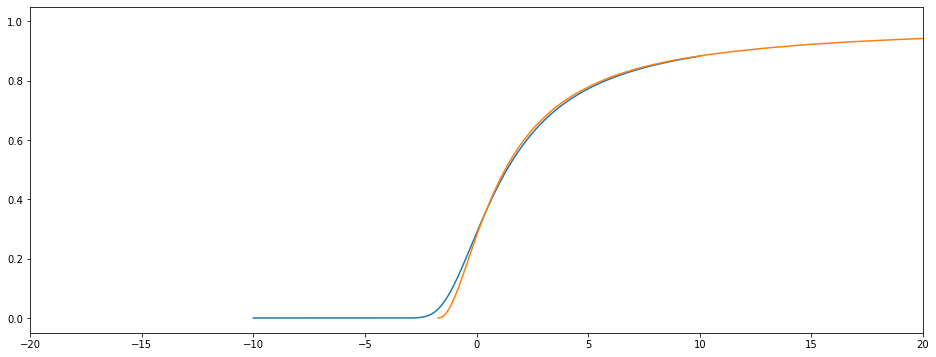

In [699]:
p.figure(figsize=(16, 6))
p.xlim([-20, 20])

x = np.linspace(-10, 10, 200)
y = [jcdf(_) for _ in x]
p.plot(x, y)

sample = sampletr(10000, 1000)
cdf(sample)
p.show()

<ipython-input-38-cc77aa20d859>:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  val, error = scipy.integrate.quad(f, 0, 100)


Generating 100000 samples of sums of 10000 independent copies of (J - 100) ∨ 0
   100000/   100000 generated


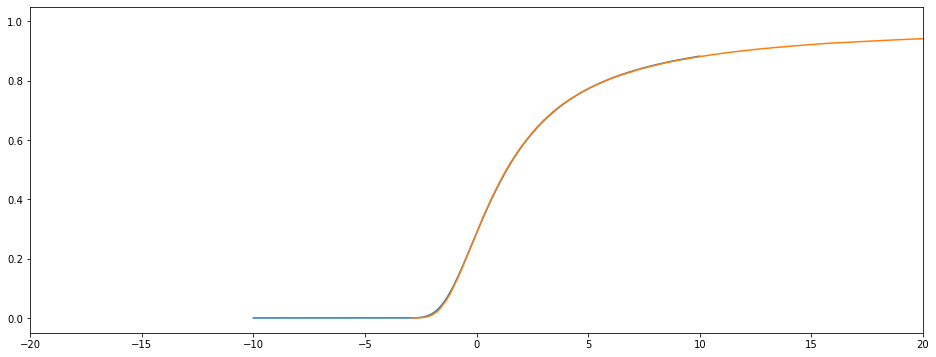

In [702]:
p.figure(figsize=(16, 6))
p.xlim([-20, 20])

x = np.linspace(-10, 10, 200)
y = [jcdf(_) for _ in x]
p.plot(x, y)

sample = sampletr(10000, 100)
cdf(sample)
p.show()